# Data Pre-processing

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

index_names = ['engine_number', 'time_cycles']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names=['sensor_measurement{}'.format(i+1) for i in range(0,23)]
col_names = index_names + setting_names + sensor_names
rul_names = ['RUL']

train1 = pd.read_csv("train_FD001.txt", header=None, sep=" ",names=col_names)
test1 = pd.read_csv("test_FD001.txt", header=None, sep=" ",names=col_names)
rul1 = pd.read_csv("RUL_FD001.txt", header=None,names=rul_names)

# Drop Nan column
train1 = train1.drop(columns=['sensor_measurement22','sensor_measurement23'],axis=1)
test1 = test1.drop(columns=['sensor_measurement22','sensor_measurement23'],axis=1)

rul1['engine_number'] = rul1.index + 1

# Remove Constant op_setting_3 and Sensor1,5,6,10,16,18,19 Column from train and test data 
drop_columns = ['op_setting_3','sensor_measurement1','sensor_measurement5','sensor_measurement6','sensor_measurement10',
               'sensor_measurement16','sensor_measurement18','sensor_measurement19']

train1_without_constant = train1.drop(columns=drop_columns, axis = 1)
test1_without_constant = test1.drop(columns = drop_columns, axis = 1)

class RULCalculator:
    def __init__(self, train_df, test_df, rul_df):
        self.train_df = train_df
        self.test_df = test_df
        self.rul_df = rul_df

    def add_rul_to_train_data(self):
        train_grouped_by_unit = self.train_df.groupby(by='engine_number')
        max_time_cycles = train_grouped_by_unit['time_cycles'].max()
        merged = self.train_df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='engine_number', right_index=True)
        merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
        merged = merged.drop("max_time_cycle", axis=1)
        return merged

    def add_rul_to_test_data(self):
        test_grouped_by_unit = self.test_df.groupby(by='engine_number')
        max_time_cycles = test_grouped_by_unit['time_cycles'].max()
        merged = self.test_df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='engine_number', right_index=True)
        merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
        merged = merged.drop("max_time_cycle", axis=1)
        return merged

    def add_rul_to_test_data_with_rul_df(self):
        test_with_rul = self.add_rul_to_test_data()
        test_with_eolrul = pd.merge(test_with_rul, self.rul_df, on='engine_number', how='left')
        test_with_eolrul['RUL'] = test_with_eolrul['RUL_x'] + test_with_eolrul['RUL_y']
        test_with_eolrul = test_with_eolrul.drop(columns=['RUL_x', 'RUL_y'], axis=1)
        return test_with_eolrul


rul_calculator = RULCalculator(train1_without_constant,test1_without_constant, rul1)


# Adding RUl in train1 data
train1_with_rul = rul_calculator.add_rul_to_train_data()
train1_with_rul

# Adding Rul data in test data using RUL Dataset
test1_with_rul = rul_calculator.add_rul_to_test_data_with_rul_df()
test1_with_rul 



,engine_number,time_cycles,op_setting_1,op_setting_2,sensor_measurement2,sensor_measurement3,sensor_measurement4,sensor_measurement7,sensor_measurement8,sensor_measurement9,sensor_measurement11,sensor_measurement12,sensor_measurement13,sensor_measurement14,sensor_measurement15,sensor_measurement17,sensor_measurement20,sensor_measurement21,RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


# CNN

Epoch 1/50
459/459 [==============================] - 6s 7ms/step - loss: 0.0065 - val_loss: 7.4669e-04
Epoch 2/50
459/459 [==============================] - 3s 6ms/step - loss: 0.0020 - val_loss: 5.5025e-04
Epoch 3/50
459/459 [==============================] - 3s 6ms/step - loss: 0.0014 - val_loss: 1.7750e-04
Epoch 4/50
459/459 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 4.6691e-04
Epoch 5/50
459/459 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 2.1103e-04
Epoch 6/50
459/459 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 9.7816e-05
Epoch 7/50
459/459 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 1.6544e-04
Epoch 8/50
459/459 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 4.7716e-04
Epoch 9/50
459/459 [==============================] - 3s 6ms/step - loss: 0.0010 - val_loss: 1.9896e-04
Epoch 10/50
459/459 [==============================] - 3s 6ms/st

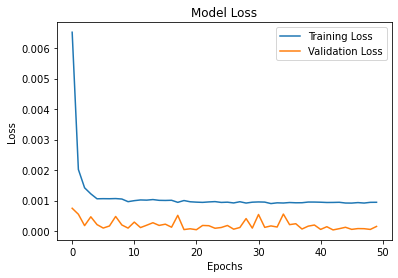

Evaluation Metrics:
Mean Squared Error (MSE): 0.0001539025656807075
Mean Absolute Error (MAE): 0.010422944708882382
R-squared (R2): 0.9934634480449716


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define prepare_data function
def prepare_data(data, sequence_length):
    engine_data = []
    for engine_no in data['engine_number'].unique():
        engine_df = data[data['engine_number'] == engine_no].iloc[:, 2:]
        num_samples = len(engine_df) - sequence_length + 1
        for i in range(num_samples):
            engine_data.append(engine_df.iloc[i:i+sequence_length].values)
    return engine_data

# Load dataset
train = train1_with_rul  # Assuming train1_with_rul and test1_with_rul are defined
test = test1_with_rul
rul = test1_with_rul['RUL']

# Preprocess data
scaler = MinMaxScaler()
train.iloc[:, 2:] = scaler.fit_transform(train.iloc[:, 2:])
test.iloc[:, 2:] = scaler.transform(test.iloc[:, 2:])

# Define sequence length
sequence_length = 24

# Define CNN model
modelCNN = Sequential()
modelCNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 17)))
modelCNN.add(MaxPooling1D(pool_size=2))
modelCNN.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelCNN.add(MaxPooling1D(pool_size=2))
modelCNN.add(Flatten())
modelCNN.add(Dense(100, activation='relu'))
modelCNN.add(Dropout(0.5))
modelCNN.add(Dense(1, activation='linear'))

# Compile the model
modelCNN.compile(optimizer=Adam(), loss='mse')

# Prepare data for CNN
X_train = prepare_data(train, sequence_length)
y_train = [data[-1][-1] for data in X_train]  # Extract RUL from the last sequence

# Convert y_train to numpy array
y_train = np.array(y_train)

# Reshape data for CNN
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

# Train the model and store history for plotting
history = modelCNN.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prepare test data
X_test = prepare_data(test, sequence_length)
y_test = [data[-1][-1] for data in X_test]  # Extract RUL from the last sequence

# Convert y_test to numpy array
y_test = np.array(y_test)

# Reshape test data for CNN
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Predict RUL for test data
y_pred = modelCNN.predict(X_test)

# Extract RUL values from predictions
rul_pred = [pred[-1] for pred in y_pred]

# Evaluate performance
mse = mean_squared_error(y_test, rul_pred)
mae = mean_absolute_error(y_test, rul_pred)
r2 = r2_score(y_test, rul_pred)

print("Evaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


# LSTM

Epoch 1/50
459/459 [==============================] - 18s 31ms/step - loss: 0.0042 - val_loss: 4.1002e-04
Epoch 2/50
459/459 [==============================] - 13s 29ms/step - loss: 0.0012 - val_loss: 1.2643e-04
Epoch 3/50
459/459 [==============================] - 14s 30ms/step - loss: 8.3702e-04 - val_loss: 1.8227e-04
Epoch 4/50
459/459 [==============================] - 14s 30ms/step - loss: 7.0468e-04 - val_loss: 2.1812e-04
Epoch 5/50
459/459 [==============================] - 13s 28ms/step - loss: 6.0052e-04 - val_loss: 1.1685e-04
Epoch 6/50
459/459 [==============================] - 12s 26ms/step - loss: 5.5519e-04 - val_loss: 7.5326e-05
Epoch 7/50
459/459 [==============================] - 13s 28ms/step - loss: 5.7026e-04 - val_loss: 5.8424e-05
Epoch 8/50
459/459 [==============================] - 13s 28ms/step - loss: 5.2625e-04 - val_loss: 4.5357e-04
Epoch 9/50
459/459 [==============================] - 12s 27ms/step - loss: 5.0339e-04 - val_loss: 7.8538e-05
Epoch 10/50
459/45

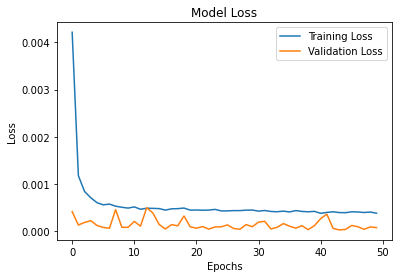

Evaluation Metrics:
Mean Squared Error (MSE): 6.947015862686927e-05
Mean Absolute Error (MAE): 0.0071038726403343765
R-squared (R2): 0.9970494624363139


In [9]:
from keras.layers import LSTM, Dense, Dropout

# Define LSTM model with corrected input shape
modelLSTM = Sequential()
modelLSTM.add(LSTM(100, input_shape=(24, 17)))  # Corrected input shape
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Dense(50, activation='relu'))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Dense(1, activation='linear'))  # Output layer with single output

# Compile the model
modelLSTM.compile(optimizer=Adam(), loss='mse')

# Prepare data for LSTM
def prepare_data(data, sequence_length):
    engine_data = []
    for engine_no in data['engine_number'].unique():
        engine_df = data[data['engine_number'] == engine_no].iloc[:, 2:]
        num_samples = len(engine_df) - sequence_length + 1
        for i in range(num_samples):
            engine_data.append(engine_df.iloc[i:i+sequence_length].values)
    return engine_data


# Train the model and store history for plotting
historyLSTM = modelLSTM.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training and validation loss
plt.plot(historyLSTM.history['loss'], label='Training Loss')
plt.plot(historyLSTM.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Predict RUL for test data
y_predLSTM = modelLSTM.predict(X_test)

# Extract RUL values from predictions
rul_predLSTM = [pred[-1] for pred in y_predLSTM]

# Evaluate performance
mseLSTM = mean_squared_error(y_test, rul_predLSTM)
maeLSTM = mean_absolute_error(y_test, rul_predLSTM)
r2LSTM = r2_score(y_test, rul_predLSTM)

print("Evaluation Metrics:")
print("Mean Squared Error (MSE):", mseLSTM)
print("Mean Absolute Error (MAE):", maeLSTM)
print("R-squared (R2):", r2LSTM)


# DRL 

Total reward: 11.019283746556473


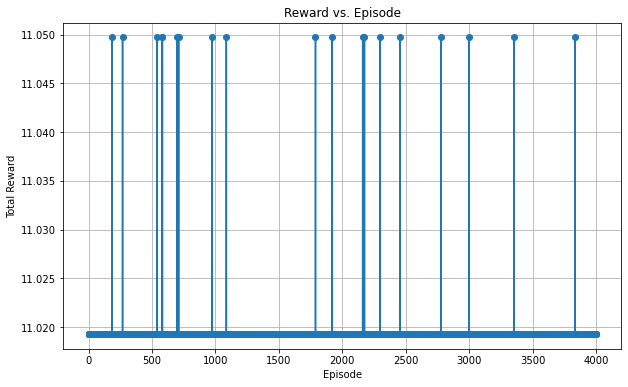

In [7]:
import gym
from gym import spaces

import numpy as np
import random

class QLearningRULPredictor:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.99, exploration_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.exploration_min = exploration_min
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.randint(0, self.action_size - 1)  # Exploration: choose random action
        else:
            return np.argmax(self.q_table[state])  # Exploitation: choose action with highest Q-value

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        q_value = self.q_table[state, action]
        next_q_value = self.q_table[next_state, best_next_action]
        new_q_value = q_value + self.learning_rate * (reward + self.discount_factor * next_q_value - q_value)
        self.q_table[state, action] = new_q_value

    def decay_exploration_rate(self):
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

class RULPredictorRL:
    def __init__(self, train_data, test_data, max_cycles):
        self.train_data = train_data
        self.test_data = test_data
        self.max_cycles = max_cycles
        self.state_size = len(train_data.columns)
        self.action_size = 2  # Two actions: 0 (no maintenance) and 1 (perform maintenance)
        self.reset()
        self.q_learner = QLearningRULPredictor(self.state_size, self.action_size)

    def reset(self):
        self.current_time_cycle = 0
        self.current_engine_index = 0
        self.done = False
        self.state = self.train_data.iloc[self.current_engine_index].values

    def step(self, action):
        if self.done:
            return self.state, 0, True, {}

        if action == 1:  # Perform maintenance
            rul = self.max_cycles - self.current_time_cycle
            reward = 4000 / (rul + 1)  # Reward inversely proportional to RUL, if you used 1000 episodes change 4000 to 1000
            self.done = True
        else:  # No maintenance
            self.current_time_cycle += 1
            if self.current_time_cycle >= self.max_cycles:
                self.current_engine_index += 1
                self.current_time_cycle = 0
                if self.current_engine_index >= len(self.train_data):
                    self.done = True
                    reward = 0
                else:
                    self.state = self.train_data.iloc[self.current_engine_index].values
                    reward = 0
            else:
                reward = 0

        return self.state, reward, self.done, {}

    def train(self, episodes=4000): # tried 1000 episodes
        rewards_per_episode = []  # List to store rewards per episode
        for episode in range(episodes):
            self.reset()
            total_reward = 0  # Initialize total reward for the episode
            while not self.done:
                action = self.q_learner.choose_action(self.current_engine_index)
                next_state, reward, self.done, _ = self.step(action)
                self.q_learner.update_q_table(self.current_engine_index, action, reward, self.current_time_cycle)
                total_reward += reward  # Accumulate reward for the episode
                self.q_learner.decay_exploration_rate()
            rewards_per_episode.append(total_reward)  # Store total reward for the episode
        return rewards_per_episode

    def test(self):
        self.reset()
        total_reward = 0
        while not self.done:
            action = np.argmax(self.q_learner.q_table[self.current_engine_index])
            _, reward, self.done, _ = self.step(action)
            total_reward += reward
        return total_reward

# Assuming you have prepared train and test data
train_data = train1_with_rul
test_data = test1_with_rul
max_cycles = train_data['time_cycles'].max()  # Assuming max cycles is available in data

# Create and initialize the RL-based RUL predictor
rul_predictor_rl = RULPredictorRL(train_data, test_data, max_cycles)

# Train the RL-based RUL predictor
rul_predictor_rl.train()

# Test the trained RL-based RUL predictor
total_reward = rul_predictor_rl.test()
print("Total reward:", total_reward)


import matplotlib.pyplot as plt

# Example rewards data (replace this with your actual rewards data)
rewards = rul_predictor_rl.train()  # Get rewards per episode from training

# Plot reward vs. episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rewards) + 1), rewards, marker='o', linestyle='-')
plt.title('Reward vs. Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()